# Analisi dei Consumi negli Stati Uniti.
Il progetto in questione vuole cercare di sfruttare la maggior parte degli strumenti appresi a lezione assieme ad alcuni approfondimenti personali per analizzare la serie storica dei consumi statunitensi dalla metà degli anni 50' fino al 2023. In primis si studierà il comportamento della serie consumi privati in un modello Vettoriale Autoregressivo (VAR) per capire la possibile influenza bidirezionale con altre variabili macroeconomiche, poi si passerà ad un'analisi di risposte ad impulso e un tentativo di previsione della serie storica in futuro. Infine si cercherà di modellare un processo ARIMA sulla serie storica per poi trarre conclusioni sul comportamento dei consumi in relazione al processo best fit considerato. I dataset utilizzati si basano su serie di dati trimestrali per:
- gdpdef: Gross domestic product deflator, il deflattore del Pil che sarà successivamente usato per comporre l'indice di inflazione della serie storica.
- ff: Federal Funds rate, il tasso effettivo dei fondi federali, ovvero il tasso di interesse interbancario.
- unrate: Uemployment rate, il tasso di disoccupazione destagionalizzato, ovvero il numero di disoccupati in rapporto alla forza lavoro (16+).
- hh_cons: Private Final Consumption Expenditure, consumo finale dei privati destagionalizzato.

## Importazione di pacchetti
Importazione di pacchetti standard per gestire database come panda e numpy, pacchetti statistici per costruire successivi modelli VAR, ARIMA e test per stazionarietà e covarianza tra i residui. Poi alcuni pacchetti grafici sono usati per visualizzare la serie temporali e gli effetti di impulso dovuti a cambiamenti nei parametri.

In [1]:
import pandas as pd
import numpy as np
import numpy.linalg as la
import datetime as dt
import itertools

from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa as sm
import pmdarima as pm

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=Warning)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})


In [2]:
np.random.seed(37)

## Toolbox
Funzioni utili da riutilizzare nel corso del progetto.
- Adfuller_test: calcola il test aumentato di Dicky-Fuller per la stazionarietà della serie storica ad un livello di significatività al 5% utilizzando il lag AR(p) proposto dal criterio informativo AIC, con annesso output e p-value per determinare se la serie sia stazionaria o meno.
- impulse_response: si basa sulla funzione irf.IRAnalysis di statsmodel a cui vengono passati dei parametri di default sia per quanto riguarda l'impulso ed il calcolo degli standard error (metodo Monte Carlo) che specialmente per la parte grafica dell'output.
- var_select: si basa sulla funzione VAR di statsmodel per calcolare il best fit di un modello vettoriale autoregressivo specificando sia l'ordine massimo che il criterio informativo.
- plot_bm: funzione per il grafico dei moti Browniani in seguito descritti.
- simple_arima: cerca il modello ARIMA che si adatta meglio al dataset senza incappare in minimi locali ma perdendo in velocità di calcolo.

In [3]:
def adfuller_test(series, signif=0.05, name=''):
    adft = adfuller(series, autolag='AIC')
    p_val = round(adft[1], 5)
    if p_val > signif:
        print(f'With a p value of {p_val} the series of {name} is Non-Stationary')
    else:
        print(f'With a p value of {p_val} the series of {name} is Stationary')

In [4]:
def impulse_response(df, order, periods, shock_sigma = -1, orthogonal=False, figsize=(20, 15), std_type='mc'):
    
    model = sm.vector_ar.var_model.VAR(endog = df)
    fitted = model.fit(order)
    sigma = fitted.sigma_u
    shock= shock_sigma*fitted.sigma_u
    irf = sm.vector_ar.irf.IRAnalysis(model = fitted, periods=periods,  P = la.cholesky(sigma))
    
    fig = irf.plot(stderr_type=std_type, figsize=figsize, orth=orthogonal, subplot_params={'fontsize':20});
    for ax in fig.axes:
            ax.lines[1].set_color('grey')
            ax.lines[1].set_linestyle(':')
            ax.lines[2].set_color('grey')
            ax.lines[2].set_linestyle(':')
            ax.lines[3].set_color('grey')
            
    if orthogonal:
        fig.suptitle('Impulse responses (orthogolanized)', fontsize=24)
    else:
        fig.suptitle('Impulse responses', fontsize=24)
    
    fig.tight_layout()

In [5]:
def var_select(df, orders=15, inf_cr= 'bic'):
    model = VAR(df)
    metrics = []
    if inf_cr == 'bic' or inf_cr == 'aic':
        for i in range(orders):
            result = model.fit(i)

            if inf_cr == 'bic':
                metrics.append(result.bic)
            elif inf_cr == 'aic':
                metrics.append(result.aic)

        return metrics.index(min(metrics))
    
    else:
        print("No valid information criteria (aic or bic) was selected")

In [6]:
def plot_bm(df, real_df, title):
    plt.plot(df, color='lightgray');
    plt.plot(real_df);
    plt.xlabel("steps")
    plt.ylabel("consumi")
    plt.title(f"Moto geometrico browniano per {title}")
    plt.margins(x=0)
    plt.tight_layout();

In [7]:
def simple_arima(df, r=4):
    comb = list(itertools.product(range(r), repeat=3))
    comb_t = [(x, y, z) for x, y, z in comb] # just to be sure

    df_comb = pd.DataFrame({'comb': comb_t})
    df_comb['BIC']= df_comb.comb.map(lambda ord_process: (ARIMA(df, order=ord_process).fit().bic))
    return df_comb.loc[df_comb['BIC'] == df_comb['BIC'].min()]

In [8]:
def df_select(df, resample_freq=None, date_format=None, time_delta=0):
    df = df.rename(columns={df.columns[0]: 'date', df.columns[1]: 'value',})
    df['date'] = pd.to_datetime(df['date'], errors='coerce', format=date_format)
    df['date'] = df['date'].apply(lambda x: x - dt.timedelta(time_delta))
    df.set_index('date', inplace = True)
    
    if resample_freq:
        df = df.resample(resample_freq).agg({'value': 'mean'})
    
    return df

# Caso studio: Stati Uniti

Per prima cosa importiamo i dataset che potrebbero essere utili allo studio del comportnamento della serie temporale dei consumi privati negli Stati Uniti precedentemente scaricati dal database FRED.

In [9]:
gdpdef = pd.read_csv('GDPDEF.csv')
ff = pd.read_csv('DFF.csv')
unrate = pd.read_csv('UNRATE.csv')
hh_cons = pd.read_csv('CONS.csv')

In [10]:
gdpdef['inflation'] = gdpdef['GDPDEF'].pct_change().dropna().copy() * 100
hh_cons['USAPFCEQDSNAQ'] = hh_cons['USAPFCEQDSNAQ'].copy()/1000000000

Costruiamo un unico dataset con tutte le informazioni di interesse combinando i singoli dataset utilizzando la funzione pd.merge() di pandas specificando sia la colonna su cui attuare l'unione, ovvero la colonna 'DATE' presente in tutti i file CSV scaricati, nonchè la modalità di unione. In questo caso usiamo la funzione 'inner' per fare in modo di ottenere un dataset contenente solamente le righe presenti in entrambi i dataset precedenti, in questo modo eliminiamo la presenza di trimestri con osservazioni mancanti.

In [11]:
dataframes_to_merge = [unrate, ff, hh_cons, gdpdef[['DATE', 'inflation']]]
macro_data = dataframes_to_merge[0]

for df in dataframes_to_merge[1:]:
    macro_data = pd.merge(macro_data, df, on='DATE', how='inner')

macro_data.columns = ['date','unrate', 'ff', 'hh_cons','inflation']
macro_data['date'] = pd.to_datetime(macro_data['date'], errors='coerce')
macro_data.set_index('date', inplace=True)

macro_data.head()

,unrate,ff,hh_cons,inflation
date,,,,
1955-01-01,4.9,1.44,1801.231,0.470208
1955-04-01,4.7,1.44,1835.737,0.409506
1955-07-01,4.0,1.69,1858.411,0.699148
1955-10-01,4.3,2.19,1881.748,0.990815
1956-01-01,4.0,2.50,1884.805,1.002578


Considerato che i modelli di regressione non gestiscono le variabili mancanti NaN (Not a Number) controlliamo che non siamo presenti nel dataset attraverso la functione isna() combinata con sum().

In [12]:
macro_data.isna().sum()

unrate       0
ff           0
hh_cons      0
inflation    0
dtype: int64

## Analisi grafica delle serie storiche

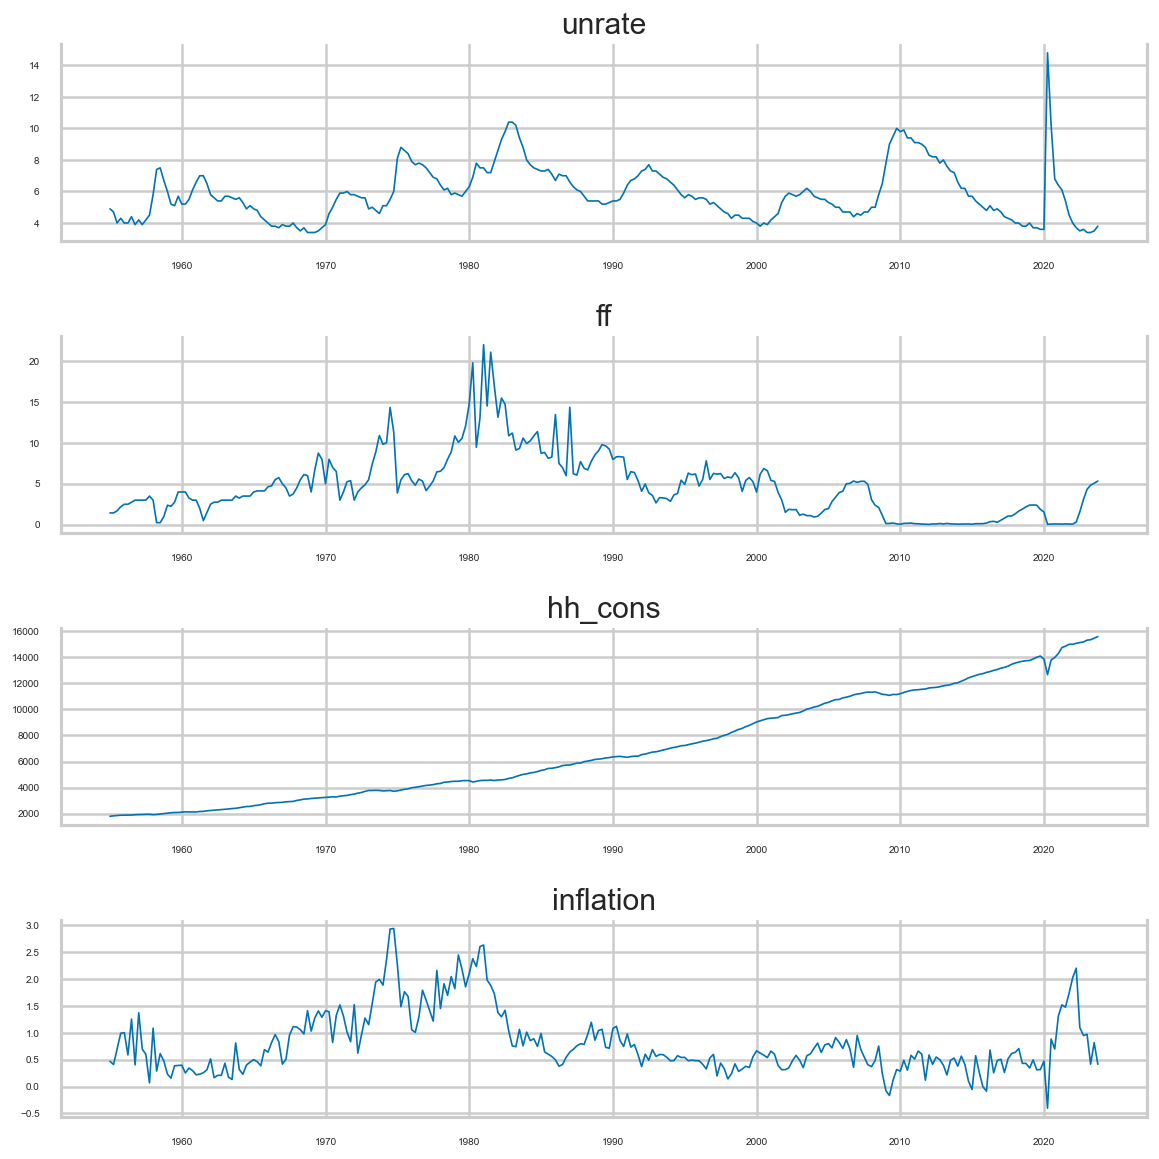

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=1, dpi=120, figsize=(10,10))
for i, ax in enumerate(axes):
    data = macro_data[macro_data.columns[i]]
    ax.plot(data, linewidth=1)
    ax.set_title(macro_data.columns[i])
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## Stazionarietà
Poiché il modello VAR richiede che le serie storiche che si desidera analizzare siano stazionarie, quindi che abbiano media e varianza costante e finita, nonchè una covarianza che non dipenda dal tempo ma solamente dal lag temporale, controlliamo  tutte le serie storiche attraverso il test di ADF (Augmented Dicky-Fuller Test) per la stazionarietà. Attraverso questo particolare test statistico si può testare l'ipotesi nulla che la serie contenga una radice unitaria e che quindi sia non stazionaria.

\begin{equation}
y_{t} = \mu + \sum_{i=1}^{p} \phi_{i} y_{t-1} + \epsilon_{t}
\end{equation}

Se la statistica test è inferiore al valore critico o se il p value è inferiore a un livello di significatività predeterminato (ad esempio 0,05), l'ipotesi nulla viene respinta e la serie storica viene considerata stazionaria, in caso contrario l'ipotesi nulla non può essere respinta e la serie è considerata non stazionaria.
Il valore critico si può trovare nella tabella di Dickey Fuller.

In [14]:
for item in macro_data.columns:
    adfuller_test(macro_data[item], name=item)

With a p value of 0.00077 the series of unrate is Stationary
With a p value of 0.18342 the series of ff is Non-Stationary
With a p value of 1.0 the series of hh_cons is Non-Stationary
With a p value of 0.24716 the series of inflation is Non-Stationary


Le serie dei tassi di interesse bancari e dei consumi privati non sono stazionarie e quindi si procede ad una differenza prima per ottenere delle serie stazionarie. Al fine di raggiungere una successiva rappresentazione sensata degli impatti di shock esogeni si procede ad una differenza prima per tutte le variabili.

In [15]:
macro_data_diff = macro_data.pct_change().dropna()

In [16]:
for item in macro_data_diff.columns:
    adfuller_test(macro_data_diff[item], name=item)

With a p value of 0.0 the series of unrate is Stationary
With a p value of 0.01337 the series of ff is Stationary
With a p value of 0.0 the series of hh_cons is Stationary
With a p value of 0.0 the series of inflation is Stationary


## Vector Autoregressive Process
Dato che le singole serie storiche sono stazionarie possiamo iniziare l'analisi. Invece di modellare ogni variabile macroeconomica a livello singolo si procede con la modellazione di un processo VAR al fine di catturare le influenze anche bidirezionali tra tutte le variabili del modello. In un certo senso ogni variabile si può vedere come endogena del sistema.

\begin{equation}
\text{VAR(P) } : Y_{t} = \Phi_{0} + \Phi_{1}Y_{t-1} + \Phi_{2}Y_{t-2} + ... + \Phi_{p}Y_{t-p} + \epsilon_{t}
\end{equation}

Per prima cosa costruiamo un oggetto VAR dalla libreria statsmodels importata in precedenza considerando la differenza prima del dataset macro_data. Poi cerchiamo attraverso un approccio iterativo il best fit al nostro dataset aumentando l'ordine del processo VAR fino ad un numero arbitrario (15). Per ogni modello estraiamo i risultati ed in particolare costruiamo un array composto dalla statistica BIC (Bayesian Information Criteria) per ognuno. Infine vediamo a quale posizione si trova il minimo di questo array al fine di trovare il processo VAR che minimizza il criterio informativo. In questo caso viene scelto un modello VAR(1).

In [17]:
var_select(macro_data_diff, inf_cr='bic', orders=15)

1

La scelta basata sul criterio informativo BIC può essere raggiunta grazie alla funzione select_order() di statsmodel che analizza, allo stesso modo del blocco di codice precedente, vari modelli di ordini diversi per raggiungere una conclusione su quale sia il best fit attraverso 4 criteri informativi, dove:
- k: numero di parametri stimati nel modello.
- n: numero di osservazioni nel dataset.
- L: massima funzione di verosimiglianza del modello (likelihood).

\begin{equation}
\text{AIC} = -2 \log(L) + 2k \ \ \ \ \ \ \ \ \ \   \text{BIC} = -2 \log(L) + k \log(n)\ \ \ \ \ \ \ \ \ \ 
\text{FPE} = \frac{n + k}{n - k} \sigma^2\ \ \ \ \ \ \ \ \ \   \text{HQIC} = -2 \log(L) + 2k \log(\log(n))
\end{equation}

Le statistiche per i criteri informativi forniscono un modo per comparare diversi modelli e determinare quale modello è più adatto ai dati, considerando sia la bontà del modello che il numero di parametri utilizzati. Vengono presi in considerazione principalmente AIC  (Akaike Information Criterion) e BIC  (Bayesian Information Criterion).  Un valore più basso di questi criteri di valutazione indica un modello migliore. Il criterio BIC  è simile all'AIC ma penalizza i modelli con un numero maggiore di parametri più severamente,  mentre il Final Prediction Error (FPE) utilizza solamente il numero di osservazioni e di parametri senza passare per la stima della funzione di massima verosimiglianza. Mentre il criterio di informazione di Hannan-Quinn (HQIC) è simile all'AIC e al BIC, ma tiene conto del numero di osservazioni nel dataset.

In [18]:
model = VAR(macro_data_diff)
model.select_order(15).summary()

,AIC,BIC,FPE,HQIC
0,-12.29,-12.23,4.604e-06,-12.27
1,-12.77,-12.49*,2.849e-06,-12.66*
2,-12.80,-12.31,2.761e-06,-12.60
3,-12.86*,-12.15,2.604e-06*,-12.57
4,-12.81,-11.88,2.732e-06,-12.44
5,-12.74,-11.59,2.937e-06,-12.28
6,-12.65,-11.28,3.220e-06,-12.10
7,-12.62,-11.03,3.314e-06,-11.98
8,-12.77,-10.96,2.867e-06,-12.04
9,-12.84,-10.81,2.682e-06,-12.02


## Best Fit (BIC)
Si procede al fit del modello VAR(1) sui dati macroeconomici come indicato dal criterio BIC. Per prima cosa, visto che successivamente la covarianza verrà calcolata utilizzando la matrice di Cholesky, che tiene in considerazione l'ordinamento nel dataset delle variabili, si riordinano le variabili secondo un criterio di influenza. Infatti si presume che uno shock al tasso di interesse dei fondi federali impatti tutte le variabili immediatamente, uno shock al tasso di disoccupazione colpisca consumi ed inflazione, mentre i consumi impattino l'inflazione ma non il tasso dei fondi federali, e che lo shock di inflazione non abbia effetto immediato.

**Matrice di Cholesky**: fattorizzazione utile se si presuppone che gli shock siano correlati tra le diverse variabili. Una matrice triangolare che impone di fatto un ordinamento negli shock. In alcuni contesti è plausibile, come nel caso di variabili macroeconomiche, che ci sia un ordinamento naturale delle infleunze dei singoli shock e che alcune serie storiche si muovano più velocemente di altre. In particolare in qusto framework uno shock all'elemento j ha effetti su ogni serie che appare dopo j  (j,...,k), ma non sugli elementi precedenti j−1 (1,..., j−1).

In [19]:
ordered_data = macro_data_diff[['ff', 'unrate', 'hh_cons','inflation']].copy()

In [21]:
results=VAR(ordered_data).fit(1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 16, May, 2024
Time:                     10:59:21
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -12.3787
Nobs:                     274.000    HQIC:                  -12.5365
Log likelihood:           196.851    FPE:                3.23211e-06
AIC:                     -12.6424    Det(Omega_mle):     3.00657e-06
--------------------------------------------------------------------
Results for equation ff
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.027551         0.044737            0.616           0.538
L1.ff                0.236707         0.060359            3.922           0.000
L1.unrate            0.199762         0.202384            0.987    

## Analisi dei residui
È possibile che nei residui sia rimasto un pattern non spiegato dal modello e che quindi ci sia autocorrelazione tra residui, per questo motivo consideriamo un test di Durbin-Watson al fine di testare l'ipotesi nulla che non esista un'autocorrelazione di ordine 1 nei residui. La statistica assume sempre un valore compreso tra 0 e 4, ed un valore di DW = 2 indica che non c'è autocorrelazione nei residui del modello.

\begin{equation}
DW = \frac{\sum_{t=2}^{T}(e_{t} - e_{t-1})^{2}}{\sum_{t=1}^{T}e_{t}^{2}}
\end{equation}

Nel nostro caso specifico possiamo notare come la statistica sia vicina al valore DW = 2, per questo possiamo sostenere che non si rimasta autocorrelazione nei residui del modello.

In [22]:
dw = durbin_watson(results.resid)

for col, val in zip(macro_data.columns, dw):
    print(col, ':', round(val, 2))

unrate : 1.96
ff : 2.05
hh_cons : 2.04
inflation : 2.02


## Causalità di Granger
La GC è il metodo standard per determinare se una variabile è utile nel predirne un'altra in un contesto di analisi vettoriale, inoltre, ottenere un'evidenza significativa a favore della GC è un buon indicatore che un VAR, piuttosto che un modello univariato, sia necessario. Nello specifico una variabile Xt non Granger causa Yt se la previsione di Yt è la stessa quando si condiziona ai valori passati di Xt o meno. Testare la causalità di Granger in un VAR(P) è implementabile utilizzando un test di verosimiglianza (likelihood ratio test).

\begin{equation}
\text{VAR(P) } : Y_{t} = \Phi_{0} + \Phi_{1}Y_{t-1} + \Phi_{2}Y_{t-2} + ... + \Phi_{p}Y_{t-p} + \epsilon_{t}
\end{equation}

\begin{equation}
H_{0} : \phi_{j,1} = \phi_{j,2} = ... = \phi_{j,p} = 0
\end{equation}

Nel caso sotto riportato testiamo se il tasso di interesse, di inflazione e la disoccupazione (tutto al livello di tassi di crescita) Granger causano a livello congiunto il consumo privato. Otteniamo un p value molto vicino allo zero, per questo possiamo rifiutare l'ipotesi nulla di non causalità e sostenere che queste variabili macroeconomiche influenzano i consumi privati.

In [23]:
results.test_causality('hh_cons', ['ff', 'inflation', 'unrate'], kind='f').summary()

Test statistic,Critical value,p-value,df
33.53,2.613,0.000,"(3, 1076)"


## Analisi di Risposta Impulsiva (Impulse Response Analysis)
Considetati i precedenti risultati si procede ad un'analisi di impulsi per capire come questo modello risponde a shock esogeni alle variabili endogene. Nello specifico si utilizzerà un processo VAR(3) seguendo il criterio AIC o VAR(1) seguendo invece il criterio BIC per mostrare il comportamento di due diversi processi che si adattano entrambi discretamente al modello macro economico sottostante, ma che per quanto riguarda le risposte a shock di tipo impulso hanno comportamenti diversi. Questo principalmente per il fatto che all'aumentare dei lag del processo i disturbi si propagano con un peso superiore tra variabili e nel tempo, creando shock più persistenti.

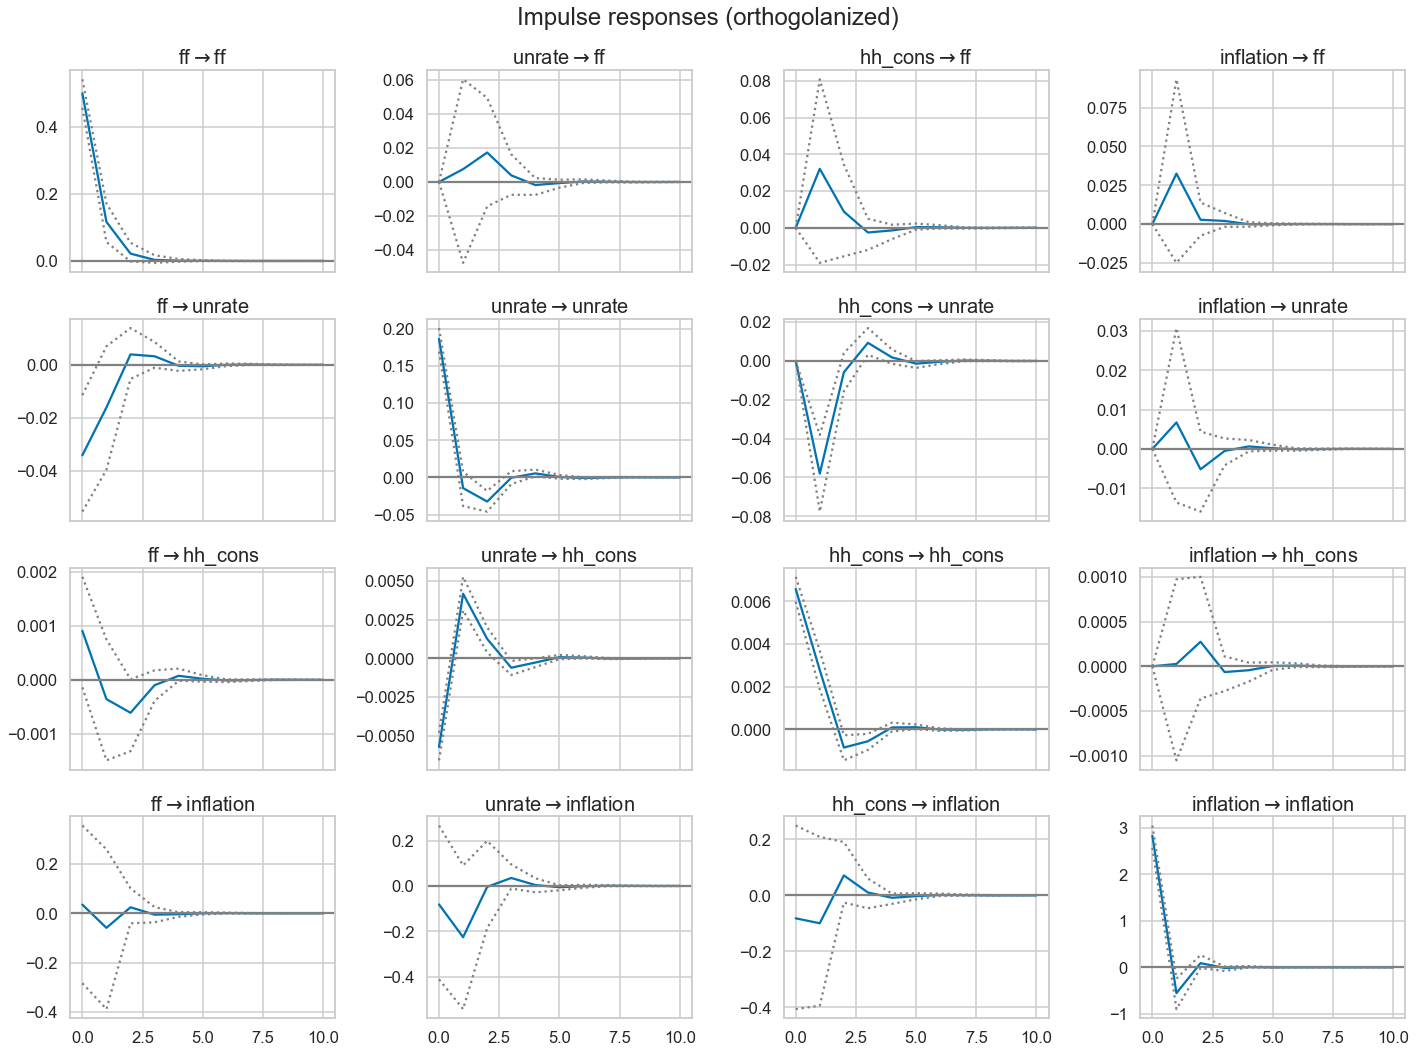

In [24]:
impulse_response(ordered_data, order=1, periods=10, orthogonal=True)

Per chiarezza di lettura ogni grafico va letto tenendo in considerazione che il sotto-grafico con titolo come ff -> hh_cons studia l'effetto di uno shock esogeno del tasso di interesse interbancario sui consumi finali dei privati.

Il processo VAR(1) comporta un'influenza tra variabili di breve periodo, per questo ad ogni shock esogeno di un errore standard corrisponde un path non troppo persistente per tornare ai valori originali. In aggiunta possiamo vedere come il modello ad impulsi restituisca un output in linea con possibili avvenimenti reali, tra questi possiamo notare per esempio che un aumento nel tasso di interesse interbancario comporta una veloce caduta del tasso di disoccupazione, questo potrebbe essere spiegato a livello macroeconomico dall'aumentare dei costi per l'input capitale nella produzione e di conseguenza la domanda di input si potrebbe spostare sul lavoro, diminuendo per questo il tasso di disoccupazione. Oppure possiamo vedere come un aumento del tasso di inflazione porti nel periodo successivo all'aumentare del tasso di interesse interbancario, questo al fine di dinimuire l'incremento inflattivo passando attraverso la diminuzione della produzione.

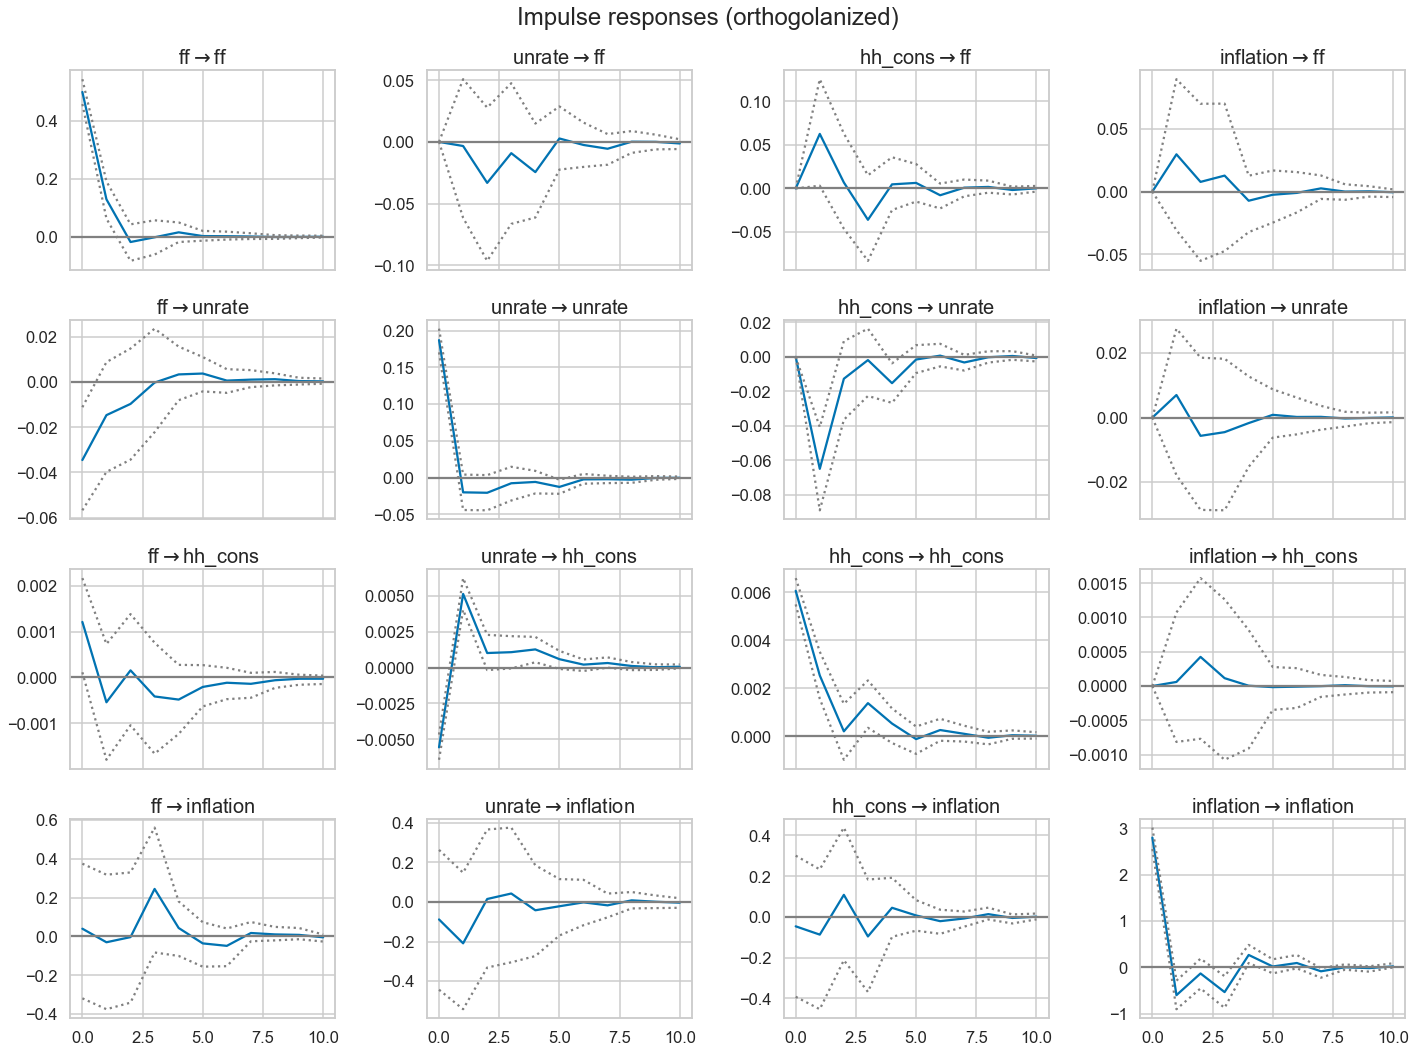

In [26]:
impulse_response(ordered_data, order=3, periods=10, orthogonal=True)

## Previsioni delle Serie Storiche
Per prima cosa si procede a dividere il dataset, poi si cerca il best fit di un modello VAR sulla serie storica rimanente con cui si costruiscono le previsioni sui 10 periodi successivi da comparare con i veri valori della serie. Poi considerato che la funzione forecast produce un output di un periodo successivo a quello inserito, si utilizza la funzione pd.DataOffset() per portare a 3 mesi successivi tutta la colonna di date nell'indice del dataset.

In [27]:
forecast_data = ordered_data.iloc[:-10]
forecast_index = ordered_data.iloc[-10:].index

In [29]:
var_order = var_select(forecast_data, inf_cr='bic', orders=15)
results = VAR(ordered_data).fit(var_order)

In [30]:
forecast_values = results.forecast(forecast_data.values, steps=10)
forecast_df = pd.DataFrame(forecast_values, index=forecast_index, columns=forecast_data.columns)

In [31]:
forecast_df.index = forecast_df.index + pd.DateOffset(months=3)

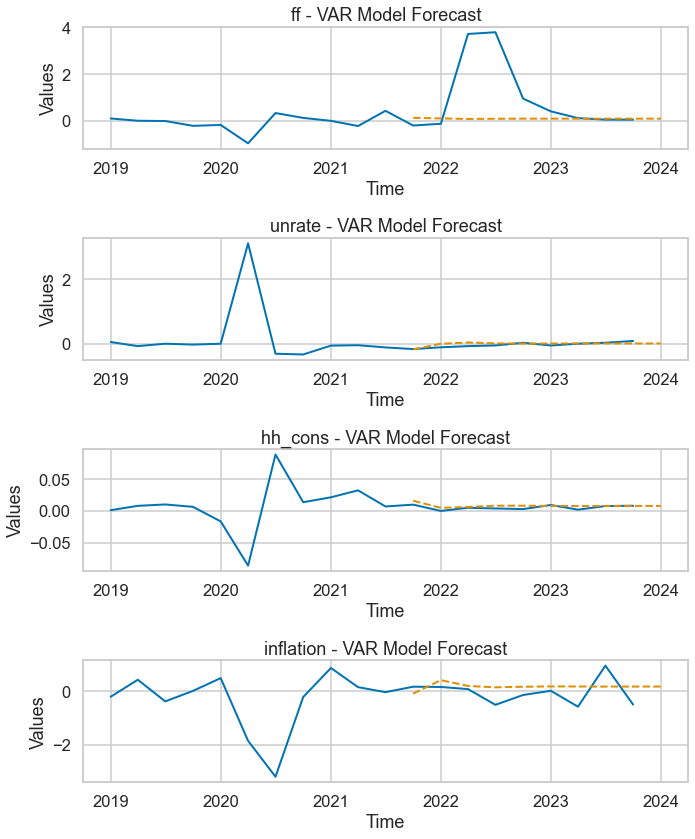

In [32]:
fig, axes = plt.subplots(nrows=len(forecast_data.columns), ncols=1, figsize=(10, 12))

for i, column in enumerate(forecast_data.columns):
    axes[i].plot(ordered_data.iloc[-20:].index, ordered_data.iloc[-20:][column], label=f'{column} - Original', linestyle='-', linewidth=2)
    axes[i].plot(forecast_df.index, forecast_df[column], label=f'{column} - Forecast', linestyle='--', linewidth=2)
    
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Values')
    axes[i].set_title(f'{column} - VAR Model Forecast')
    
plt.tight_layout()
plt.show()

# Moti Browniani e Consumi privati USA
In questa sezione si procede a creare un grafico che comprenda sia la serie realizzata dei consumi privati statunitensi che, attraverso il fit di modelli ARIMA, alcune delle altre infinite possibili serie storiche che si sarebbero potute realizzare attraverso lo stesso processo. Si procede perciò alla ricerca del best fit per la serie storica con particolare attenzione all'uso del test ADF al fine di comprendere se la serie sia stazionaria o meno nel caso di consumi non differenziati.

In [33]:
hh_cons = pd.read_csv('CONS.csv')
hh_cons['USAPFCEQDSNAQ'] = hh_cons['USAPFCEQDSNAQ'].copy()/1000000000
hh_cons['DATE'] = pd.to_datetime(hh_cons['DATE'], errors='coerce')
hh_cons.set_index('DATE', inplace=True)
hh_cons = hh_cons.rename(columns={'USAPFCEQDSNAQ': 'hh_cons'})

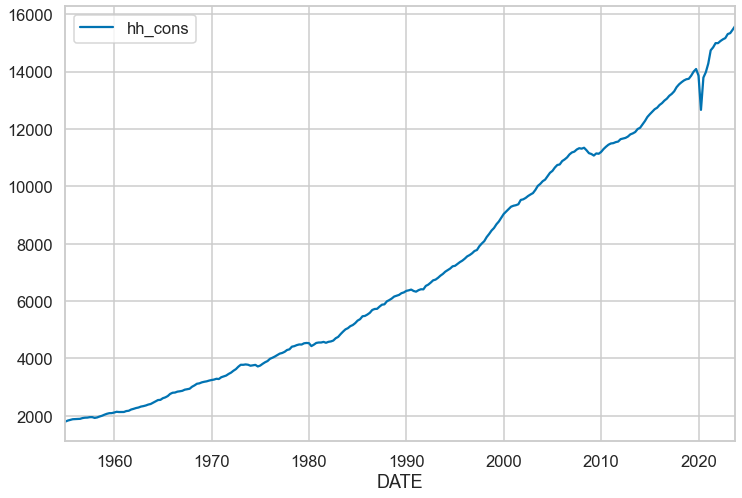

In [34]:
hh_cons.plot();

In [35]:
auto_arima = pm.auto_arima(hh_cons,
                           test="adf",
                           seasonal=True,
                           with_intercept=False,
                           stepwise=True,
                           suppress_warnings=True,
                           trace=False)
                            
auto_arima.order, auto_arima.aic()

((1, 1, 2), 3382.561568141772)

### Consumi: ARIMA (1,1,2)
Attraverso la funzione auto_arima si raggiunge un processo ARIMA (1,1,2) testandone la stazionarietà con un test ADF, ora si procede con la costruzione di una funzione che riproduca lo stesso processo attraverso i parametri del modello per poi combinare i risultati in un dataframe. Questo sarà composto dalle prime due osservazioni della serie storica originale, al fine di fornire al modello i lag necessari al calcolo della variabile dipendente, e delle osservazioni simulate. Infine si controlla che il dataset inizi effettivamente dai valori veri della serie sui consumi, si condivide l'indice temporale dei consumi con tutte le simulazioni e si traccia il grafico di simulazioni (nello sfondo il grigio chiaro) e della vera realizzazione (blu) dei consumi.

In [36]:
params=auto_arima.params()

N=10000
steps = len(hh_cons)  # Number of rows (time steps)
ar_L1 = params[0]  # Autoregressive coefficient (phi1)
ma_L1 = params[1]  # Moving average coefficient for lag 1 (theta1)
ma_L2 = params[2]  # Moving average coefficient for lag 2 (theta2)
sigma2 = params[3] # Errors of the residuals
beta = 0.002
noise_scale = np.sqrt(sigma2)  # Scale of random noise (epsilon)

time_series = pd.DataFrame()

for col in range(N):
    y = np.zeros(steps)
    epsilon = np.zeros(steps)
    y[0] = hh_cons['hh_cons'][0]  # Initial value for y[t-2]
    y[1] = hh_cons['hh_cons'][1]  # Initial value for y[t-1]

    for t in range(2,steps):
        epsilon_t = np.random.normal(scale=noise_scale)
        y_t = y[t-1] + beta*t + ar_L1 * (y[t-1] - y[t-2]) + ma_L1 * epsilon[t-1] + ma_L2 * epsilon[t-2] + epsilon_t

        y[t] = y_t
        epsilon[t] = epsilon_t

    time_series[f'y_{col + 1}'] = y

df = pd.DataFrame(time_series)

In [ ]:
params

In [37]:
df.head()

,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,...,y_9991,y_9992,y_9993,y_9994,y_9995,y_9996,y_9997,y_9998,y_9999,y_10000
0,1801.231000,1801.231000,1801.231000,1801.231000,1801.231000,1801.231000,1801.231000,1801.231000,1801.231000,1801.231000,...,1801.231000,1801.231000,1801.231000,1801.231000,1801.231000,1801.231000,1801.231000,1801.231000,1801.231000,1801.231000
1,1835.737000,1835.737000,1835.737000,1835.737000,1835.737000,1835.737000,1835.737000,1835.737000,1835.737000,1835.737000,...,1835.737000,1835.737000,1835.737000,1835.737000,1835.737000,1835.737000,1835.737000,1835.737000,1835.737000,1835.737000
2,1864.151022,1809.236827,1858.120811,2048.359306,1784.023464,1765.966602,1915.802916,1820.440539,1801.992487,1832.149032,...,1878.924746,1931.672438,1743.133220,1769.191020,1979.684536,1979.145607,1798.935756,1998.065353,2070.619653,1974.109638
3,1974.599164,1826.172202,2066.020192,2109.358403,1640.612457,1756.963519,1775.274561,1818.000454,1849.040609,1819.174703,...,1895.790307,2026.736184,1774.978175,1858.692613,1975.504653,2077.211099,1913.800901,2076.819300,2325.128365,1974.528734
4,2036.505654,1839.997020,1953.619698,2150.361242,1649.650522,1701.452748,1828.751242,1900.226527,1867.691916,1962.634170,...,1849.644890,2038.257745,1885.370141,1683.534488,2103.432277,1965.298109,2011.400956,1982.339798,2290.010450,1924.676294


In [38]:
df.index = hh_cons.index

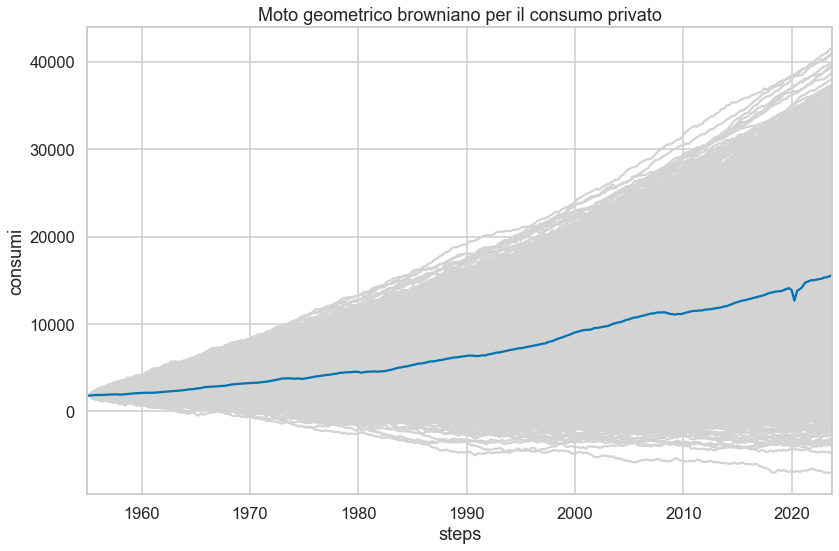

In [39]:
plot_bm(df, hh_cons, 'il consumo privato')

Nella funzione è presente un parametro arbitrario beta al fine di rendere non lineare il comportamento del modello, avvicinandosi al movimento esponenziale dei consumi statunitensi. Al fine di calibrare al meglio il parametro si utilizza un istogramma da centrare sul valore scelto di beta, nel caso specifico ß = 0.02

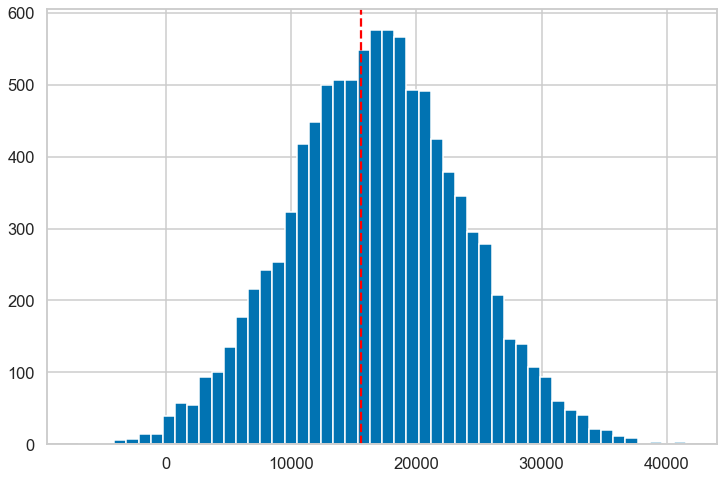

In [40]:
cons_end = hh_cons['hh_cons'][-1]
plt.hist(df.iloc[-1], bins=50);
plt.axvline(cons_end, color='red', linestyle='--');

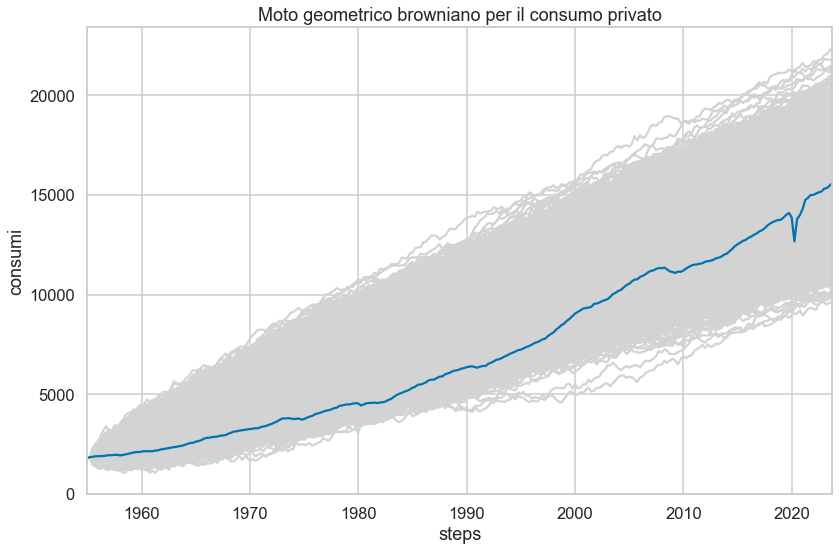

In [41]:
auto_arima_110 = pm.auto_arima(hh_cons,
                           test="adf",
                           seasonal=True,
                           with_intercept=True,
                           stepwise=True,
                           suppress_warnings=True,
                           trace=False)

params=auto_arima_110.params()

N=10000
steps = len(hh_cons)  # Number of rows (time steps)
intercept = params[0]  
ar_L1 = params[1]  
sigma2 = params[2]
beta = 0.001
noise_scale = np.sqrt(sigma2)

time_series = pd.DataFrame()

for col in range(N):
    y = np.zeros(steps)
    epsilon = np.zeros(steps)
    y[0] = hh_cons['hh_cons'][0]  # Initial value for y[t-2]
    y[1] = hh_cons['hh_cons'][1]  # Initial value for y[t-1]

    for t in range(2,steps):
        epsilon_t = np.random.normal(scale=noise_scale)
        y_t = intercept + y[t-1]  + ar_L1 * (y[t-1] - y[t-2]) + epsilon_t

        y[t] = y_t
        epsilon[t] = epsilon_t

    time_series[f'y_{col + 1}'] = y

df_110 = pd.DataFrame(time_series)
df_110.index = hh_cons.index
plot_bm(df_110, hh_cons, 'il consumo privato')

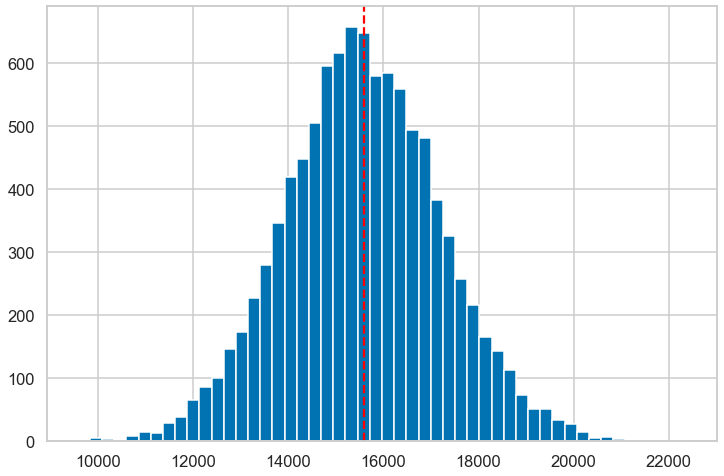

In [42]:
cons_end = hh_cons['hh_cons'][-1]
plt.hist(df_110.iloc[-1], bins=50);
plt.axvline(cons_end, color='red', linestyle='--');

### Crescita dei Consumi: ARIMA (p,0,q)
Nell'analisi del tasso di crescita dei consumi, ottenuto con la differenza prima (o percentuale) rispetto al periodo precedente si nota un effetto interessante sulla funzione auto_arima di pmdarima. Nel momento in cui si forza il modello a non avere un intercetta, il best fit secondo il criterio Bic risulta un processo ARIMA(1,0,1), con intercetta 0.007930 ma con parametri ar.L1 e ar.L1 statisticamente non significativi. Mentre se non si forza l'intercetta, si ottiene tramite sia Aic che Bic un processo White Noise (ARIMA(0,0,0)) in cui l'intercetta ha un valore molto simile di 0.007925 senza altri parametri, con un errore nei residui più lieve rispetto al modello con più parametri. Questa conclusione potrebbe essere un incentivo a non forzare l'annullamento di parametri nel modello, specialmente dell'intercetta.

In [43]:
hh_cons_diff = hh_cons.pct_change().dropna()

inf_crit = ['aic', 'bic']
intercept = [True, False]

dfi = pd.DataFrame(columns=inf_crit, index=intercept)

for crit in inf_crit: 
    for inter in intercept:
        auto_arima = pm.auto_arima(hh_cons_diff,
                                   with_intercept=inter,
                                   information_criterion=crit,
                                   stepwise=True,
                                   suppress_warnings=True,
                                   trace=False)
        dfi[crit][inter] = auto_arima.order

dfi.head()

,aic,bic
True,"(0, 0, 0)","(0, 0, 0)"
False,"(0, 0, 0)","(1, 0, 1)"


In [44]:
adfuller_test(hh_cons_diff, name='hh_cons_diff')

With a p value of 0.0 the series of hh_cons_diff is Stationary


In [45]:
model = ARIMA(hh_cons_diff, order=dfi['aic'][False])
fitted_nia = model.fit()
fitted_nia.params

const     0.007925
sigma2    0.000104
dtype: float64

In [46]:
params = fitted_nia.params  # (0,0,0)
intercept = params[0]
sigma2 = params[1]
noise_scale = np.sqrt(sigma2)

steps= len(hh_cons_diff)
N = 1000
epsilon= np.random.normal(scale=noise_scale, size=(steps,N))

consg = intercept + epsilon
consg_df = pd.DataFrame(consg)
consg_df.index = hh_cons_diff.index

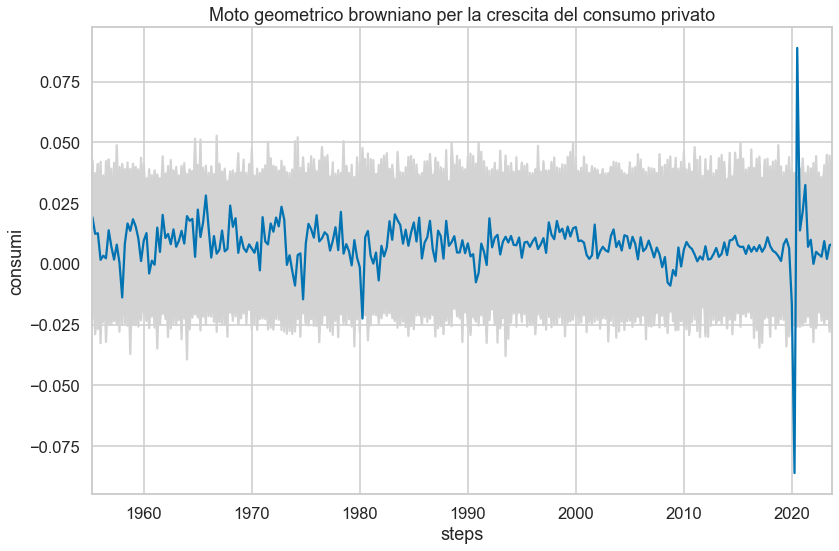

In [47]:
plot_bm(consg_df, hh_cons_diff, 'la crescita del consumo privato')

In [48]:
auto_arima = pm.auto_arima(hh_cons_diff,
                                   with_intercept=False,
                                   information_criterion='bic',
                                   stepwise=True,
                                   suppress_warnings=True,
                                   trace=False)
auto_arima.order, auto_arima.aic()

((1, 0, 1), -1731.4916568254678)

In [49]:
model = ARIMA(hh_cons_diff, order=dfi['bic'][False])
fitted_i = model.fit()
fitted_i.params

const     0.007930
ar.L1     0.000000
ma.L1    -0.000000
sigma2    0.000104
dtype: float64

## Funzione Simple_arima e ARIMA (0,2,2)
Considerato che la funzione auto.arima è soggetta a cadere in minimi locali, è possibile che esista un processo ARIMA che si adatti meglio ai dati. Per questo costruisco la funzione simple_arima trovando che un modello con minore BIC e AIC è un ARIMA (0,2,2). Il problema di questo modello è la difficile interpretazione grafica successiva, per questo si è preferito utilizzare il processo deciso dalla funzione auto.arima per il grafico sui moti Browniani.

In [50]:
simple_arima(hh_cons, r=4)

,comb,BIC
10,"(0, 2, 2)",3380.67686


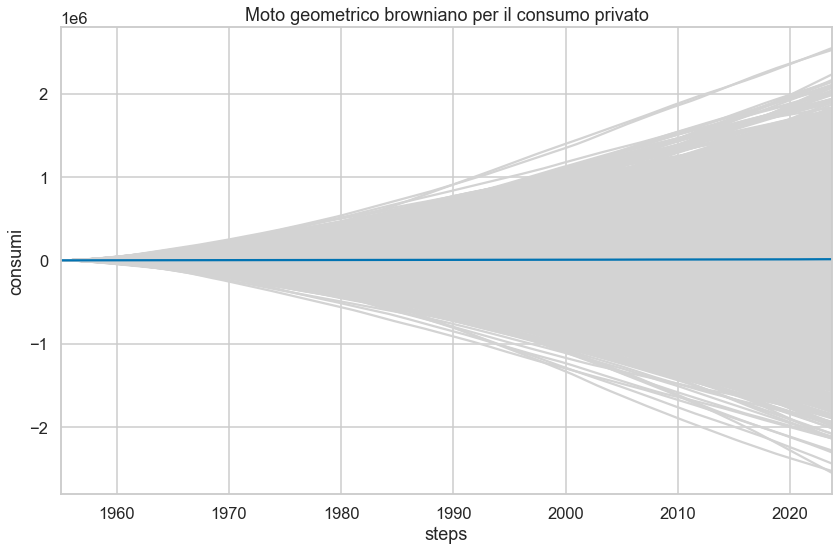

In [51]:
sa = ARIMA(hh_cons, order=(0, 2, 2)).fit()
params = sa.params
N=10000
steps = len(hh_cons) 
ma_L1 = params[0]  
ma_L2 = params[1] 
sigma2 = params[2]
noise_scale = np.sqrt(sigma2)

time_series = pd.DataFrame()

for col in range(N):
    y = np.zeros(steps)
    epsilon = np.zeros(steps)
    y[0] = hh_cons['hh_cons'][0] 
    y[1] = hh_cons['hh_cons'][1] 

    for t in range(2,steps):
        epsilon_t = np.random.normal(scale=noise_scale)
        y_t = 2*y[t-1] - y[t-2] - ma_L1* epsilon[t-1] + ma_L2*epsilon[t-2] + epsilon_t

        y[t] = y_t
        epsilon[t] = epsilon_t

    time_series[f'y_{col + 1}'] = y

df = pd.DataFrame(time_series)
df.index = hh_cons.index

plot_bm(df, hh_cons, 'il consumo privato')

In [52]:
sa.params

ma.L1        -1.146047
ma.L2         0.167515
sigma2    12410.777622
dtype: float64

## Fine
Spero sia stato tutto il più chiaro possibile.